<a href="https://colab.research.google.com/github/brahma2024/LLM-study/blob/main/2_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer Perceptron implementation

Referring to Paper - https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read  in all the words
!wget "https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt"

--2024-05-21 18:40:41--  https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228146 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-05-21 18:40:41 (5.89 MB/s) - ‘names.txt’ saved [228146/228146]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
for j,l in enumerate(['a','b','c','c','e']):
  print(f'{j=}')
  print(f'{l=}')

j=0
l='a'
j=1
l='b'
j=2
l='c'
j=3
l='c'
j=4
l='e'


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [ ]:
for a, b in stoi.items():
  # print(f'{i} : {s}')
  print(b, a)


1 a
2 b
3 c
4 d
5 e
6 f
7 g
8 h
9 i
10 j
11 k
12 l
13 m
14 n
15 o
16 p
17 q
18 r
19 s
20 t
21 u
22 v
23 w
24 x
25 y
26 z
0 .


In [ ]:
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 # context length: how many chracters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

  print(w)
  context = [0] * block_size
  print(f'{context=}')
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
context=[0, 0, 0]
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
context=[0, 0, 0]
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
context=[0, 0, 0]
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
context=[0, 0, 0]
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
context=[0, 0, 0]
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [ ]:
X.shape[0], X.dtype, Y.shape, Y.dtype

(32, torch.int64, torch.Size([32]), torch.int64)

In [ ]:
# Create embedding layer
# Lets assume the feature space for the character level embedding is 2-d
# So we need to create a embedding matrix for all input chracters = 27
# each of 27 chracters will have a 2-dimensional embedding
C = torch.randn(27, 2) # C is the embedding matrix of the lookup table
C

tensor([[ 0.4998,  0.9442],
        [-2.0079,  0.5173],
        [ 0.8081,  0.2574],
        [-0.4558, -1.0191],
        [-1.0451,  0.3573],
        [-0.7437,  1.0455],
        [ 0.9225, -0.2262],
        [-0.8290,  0.2550],
        [-0.9293, -0.3977],
        [-1.0748,  0.4623],
        [ 0.5911, -0.2089],
        [-0.0267, -0.1277],
        [-0.3262,  0.7780],
        [-0.0145,  0.4582],
        [-0.3788,  0.8474],
        [-1.0911, -0.3781],
        [-0.2178, -1.7937],
        [ 0.1503,  0.1575],
        [-1.3674,  1.6330],
        [-0.9467, -0.7479],
        [-1.9713, -0.9092],
        [-0.1619,  1.0189],
        [ 1.2755,  0.4463],
        [-0.8701, -0.2758],
        [-1.7664,  1.3306],
        [-1.3553,  1.3176],
        [-1.9010, -0.0353]])

In [ ]:
 # embedding for a given chracter
 # get the integer corresponding to the character and index into that ix in lookup table C
 ix = stoi['b']
 C[ix]

tensor([0.8081, 0.2574])

In [ ]:
C[X].shape

torch.Size([228146, 3, 2])

In [ ]:
# in the Bigram Model we took ix for each character and used
# One-hot encoding to first encode them
emb_oneHot = F.one_hot(torch.tensor(5), num_classes=27)
emb_oneHot.dtype

torch.int64

In [ ]:
# so to fetch the embedding for row 5 we multiply the F.one_hot with C, which will pluck out the row corresponding to ix
print(emb_oneHot.float() @ C)
print(C[5])
# since everything in the one-hot encoding is 0 - it masks out all other layers, excpet one for ix -> which essentially is the samething as embedding C[ix] directly

tensor([-0.7437,  1.0455])
tensor([-0.7437,  1.0455])


In [ ]:
# we will index integers and use embedding tables
# Now embedding a single integer 5 is easy, for multi-dimensional embedding we use pytorch indexing
X.shape

torch.Size([32, 3])

In [ ]:
# this is how pytorch indexing works
# indexing can also be done using lists C[[ix1, ix2, ix3]]
C[[5, 6]] # from embedding look up table C, picks out embeddings for row 5, 6

tensor([[-0.7437,  1.0455],
        [ 0.9225, -0.2262]])

In [ ]:
C[[5, 6, 7, 7, 7]] # returns embeddings for row 7 as many times as called

# Can also index with tensors
C[torch.tensor([5, 6, 6])]

tensor([[-0.7437,  1.0455],
        [ 0.9225, -0.2262],
        [ 0.9225, -0.2262]])

In [ ]:
# So we can simply index by X directly
C[X]

tensor([[[ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442]],

        [[ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-0.7437,  1.0455]],

        [[ 0.4998,  0.9442],
         [-0.7437,  1.0455],
         [-0.0145,  0.4582]],

        [[-0.7437,  1.0455],
         [-0.0145,  0.4582],
         [-0.0145,  0.4582]],

        [[-0.0145,  0.4582],
         [-0.0145,  0.4582],
         [-2.0079,  0.5173]],

        [[ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442]],

        [[ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-1.0911, -0.3781]],

        [[ 0.4998,  0.9442],
         [-1.0911, -0.3781],
         [-0.3262,  0.7780]],

        [[-1.0911, -0.3781],
         [-0.3262,  0.7780],
         [-1.0748,  0.4623]],

        [[-0.3262,  0.7780],
         [-1.0748,  0.4623],
         [ 1.2755,  0.4463]],

        [[-1.0748,  0.4623],
         [ 1.2755,  0.4463],
         [-1.0748,  0.4623]],

        [[ 1.2755,  0

In [ ]:
C[X].shape

torch.Size([32, 3, 2])

In [ ]:
X[13, 2], C[X[13, 2]]

(tensor(1), tensor([-2.0079,  0.5173]))

In [ ]:
C[1], C[1] == C[X[13,2]] # Element wise comparison

(tensor([-2.0079,  0.5173]), tensor([True, True]))

In [ ]:
# So the embedding layer can be written as
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
# Create the 1st hidden layer
W1 = torch.randn(6, 100) # 3 character of context + 2-d embedding for each makes it 6 inputs + say we have 100 neurons
b1 = torch.randn(100) # 1 bias value for each 100 neurons

In [ ]:
# next, dot product of inputs embedding layer with each neuron
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [ ]:
# the above error is because shape of emb is 32 x 3 x 2 and we are trying to multiple it with matrix W1 os size 6 x 100
# So we need to transform 32 x 3 x 2 to 32 x 6

# Method 1: Concatenate the 3 enbeddings for each inputs (refer Fig 1 on the paper)
# So we grab embeddings for all 3 inputs in context and contcatenate them
emb[:, 0, :] # plucks out all 32 x 2 embeddings of the 1st inputs character

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [ ]:
# limitation with the above method is that its hardcoded to block_size 3
# if the block_size changes, we have to manually update the code to edit the concatenation

# METHOD 2: Remove the 2nd tensor dimension using Pytorch.unbind
# returns a tuple of all slices given dimensions, already without it
torch.unbind(emb, 1)


(tensor([[ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-0.7437,  1.0455],
         [-0.0145,  0.4582],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-1.0911, -0.3781],
         [-0.3262,  0.7780],
         [-1.0748,  0.4623],
         [ 1.2755,  0.4463],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-2.0079,  0.5173],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-1.0748,  0.4623],
         [-0.9467, -0.7479],
         [-2.0079,  0.5173],
         [ 0.8081,  0.2574],
         [-0.7437,  1.0455],
         [-0.3262,  0.7780],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-0.9467, -0.7479],
         [-1.0911, -0.3781],
         [-0.2178, -1.7937],
         [-0.9293, -0.3977]]),
 tensor([[ 0.4998,  0.9442],
         [ 0.4998,  0.9442],
         [-0

In [ ]:
len(torch.unbind(emb, 1))
# first unbind the embedding matrix along the 1st dimension this is where we have character level indexing
# next we concatenate all the embeddings for the 1st, 2nd and 3rd character
torch.cat(torch.unbind(emb, 1), 1) # another issue with this is torch.cat creates a whole new vector and takes as much memory

tensor([[ 0.4998,  0.9442,  0.4998,  0.9442,  0.4998,  0.9442],
        [ 0.4998,  0.9442,  0.4998,  0.9442, -0.7437,  1.0455],
        [ 0.4998,  0.9442, -0.7437,  1.0455, -0.0145,  0.4582],
        [-0.7437,  1.0455, -0.0145,  0.4582, -0.0145,  0.4582],
        [-0.0145,  0.4582, -0.0145,  0.4582, -2.0079,  0.5173],
        [ 0.4998,  0.9442,  0.4998,  0.9442,  0.4998,  0.9442],
        [ 0.4998,  0.9442,  0.4998,  0.9442, -1.0911, -0.3781],
        [ 0.4998,  0.9442, -1.0911, -0.3781, -0.3262,  0.7780],
        [-1.0911, -0.3781, -0.3262,  0.7780, -1.0748,  0.4623],
        [-0.3262,  0.7780, -1.0748,  0.4623,  1.2755,  0.4463],
        [-1.0748,  0.4623,  1.2755,  0.4463, -1.0748,  0.4623],
        [ 1.2755,  0.4463, -1.0748,  0.4623, -2.0079,  0.5173],
        [ 0.4998,  0.9442,  0.4998,  0.9442,  0.4998,  0.9442],
        [ 0.4998,  0.9442,  0.4998,  0.9442, -2.0079,  0.5173],
        [ 0.4998,  0.9442, -2.0079,  0.5173,  1.2755,  0.4463],
        [-2.0079,  0.5173,  1.2755,  0.4

In [ ]:
# Method 3: using views
# views essentially represents a stored tensor in different-sized n-dimensionsal tensors
# an example here
a = torch.arange(8)
a.storage()

<ipython-input-31-b989bf0a21e1>:5: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 8]

In [ ]:
# using views to represent tensor a in different-sized n-dimensional tensor
a.view(2,2,2), "---------", a.view(2,4)

(tensor([[[0, 1],
          [2, 3]],
 
         [[4, 5],
          [6, 7]]]),
 '---------',
 tensor([[0, 1, 2, 3],
         [4, 5, 6, 7]]))

In [ ]:
# using view to represent our emb tensor as 32 x 6
print(emb.shape)
print(emb.view(32, 6)) # dimension 1 gets stacked up in a single row - similar to the concatenation operation we tried above

torch.Size([32, 3, 2])
tensor([[ 0.4998,  0.9442,  0.4998,  0.9442,  0.4998,  0.9442],
        [ 0.4998,  0.9442,  0.4998,  0.9442, -0.7437,  1.0455],
        [ 0.4998,  0.9442, -0.7437,  1.0455, -0.0145,  0.4582],
        [-0.7437,  1.0455, -0.0145,  0.4582, -0.0145,  0.4582],
        [-0.0145,  0.4582, -0.0145,  0.4582, -2.0079,  0.5173],
        [ 0.4998,  0.9442,  0.4998,  0.9442,  0.4998,  0.9442],
        [ 0.4998,  0.9442,  0.4998,  0.9442, -1.0911, -0.3781],
        [ 0.4998,  0.9442, -1.0911, -0.3781, -0.3262,  0.7780],
        [-1.0911, -0.3781, -0.3262,  0.7780, -1.0748,  0.4623],
        [-0.3262,  0.7780, -1.0748,  0.4623,  1.2755,  0.4463],
        [-1.0748,  0.4623,  1.2755,  0.4463, -1.0748,  0.4623],
        [ 1.2755,  0.4463, -1.0748,  0.4623, -2.0079,  0.5173],
        [ 0.4998,  0.9442,  0.4998,  0.9442,  0.4998,  0.9442],
        [ 0.4998,  0.9442,  0.4998,  0.9442, -2.0079,  0.5173],
        [ 0.4998,  0.9442, -2.0079,  0.5173,  1.2755,  0.4463],
        [-2.0079,

In [ ]:
# doing an element-wise comparison
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [ ]:
# finding the hidden state by doing matrix multiplication between embedding layer output @ hidden layer
emb.view(32, 6) @ W1 + b1

tensor([[-2.6978, -0.4593,  0.4989,  ..., -1.3648, -0.9036, -3.2040],
        [-4.6755, -0.4556,  0.5482,  ..., -1.3940,  0.9420, -3.2466],
        [-4.4316,  0.6233, -1.5183,  ..., -1.7686, -0.1924, -2.3025],
        ...,
        [-1.5694,  2.2975,  0.7654,  ...,  1.0073,  3.8155,  5.0145],
        [-3.0329,  3.8626, -0.7667,  ..., -0.4080,  0.5472,  2.2970],
        [-5.6827,  2.0878, -2.9885,  ..., -0.9401,  3.7473,  1.2118]])

In [ ]:
# using tanh activation
h = torch.tanh(emb.view(32, 6) @ W1 + b1)
h.shape # 100-dimensional activations for each of our 32 examples

torch.Size([32, 100])

In [ ]:
# instead of using hardcoded values of 32, we use emb.shape[0]
# + b1 will broadcast like this
# 32, 100
# 1,  100
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # also be very careful with broadcasting
h.shape

torch.Size([32, 100])

In [ ]:
# Creating the final layer
W2 = torch.randn(100, 27) # 100 inputs from 100 nuerons from hidden layer + 27 possible output characters
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [ ]:
logits

tensor([[ 5.0959e-01,  1.7014e+00, -5.1569e+00, -6.0552e-01, -1.9362e+00,
          1.0021e+00,  3.1801e+00, -9.9484e-01,  2.1217e+00, -2.3047e+00,
          1.3121e+00,  5.3177e+00, -1.0402e+01, -1.6124e+01, -5.6617e+00,
          1.0573e+01, -7.0289e-03,  5.4285e+00, -1.7740e+00, -3.3063e+00,
         -2.7629e+00,  4.7392e+00, -1.3612e+00,  1.1407e+01,  8.5912e+00,
         -1.6937e+00, -6.3124e+00],
        [-1.1373e+01,  1.0274e+01, -2.0230e+00,  5.3747e-01, -1.3459e+01,
          2.6754e+00,  4.7626e+00, -1.0503e+01, -5.3951e+00, -4.3532e+00,
         -6.5560e+00, -1.3954e-01, -2.4445e+00, -4.8724e+00,  7.9449e-01,
          1.5103e+01,  3.5683e-01,  6.7147e+00,  2.8541e+00,  4.5760e+00,
         -1.0051e+01, -1.5716e+00,  9.6432e-02,  9.0255e+00,  8.5908e+00,
         -1.4446e+00, -3.9499e+00],
        [-1.4826e+00,  7.9846e+00, -1.7583e+00,  7.0213e+00, -2.9937e-01,
         -3.1055e-01,  9.9371e+00, -1.7953e-01, -1.9104e+00,  2.4139e+00,
          4.0429e+00,  1.2403e+01, -3.61

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True) # gives the probability distribution for each of the 27 characters to occur in case of each of 32 examples
prob.shape

torch.Size([32, 27])

In [ ]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [ ]:
# prob[1, 2] # fist selects example 1 and then plucks out the probablity of character corresponding to integer 2

# Using the above references to porb tensor
# For each example row, pluck out the probability for the index/integer in Y
prob[torch.arange(32), Y]
# ideally probabilities for each of the Y should be 1 - thats the goal

tensor([2.0172e-05, 2.0868e-09, 3.1523e-15, 9.9938e-01, 3.1710e-16, 2.8940e-01,
        3.5557e-09, 6.6063e-05, 4.0782e-06, 1.1159e-08, 3.1977e-01, 1.1821e-12,
        4.0591e-05, 3.8820e-08, 4.2597e-04, 2.3879e-14, 7.3896e-07, 2.6636e-04,
        6.6198e-04, 1.6110e-06, 2.7785e-06, 6.0859e-06, 5.9246e-08, 7.1904e-01,
        7.8502e-17, 2.7140e-07, 5.9583e-06, 1.8125e-08, 9.9592e-18, 1.0927e-03,
        1.1892e-08, 3.7667e-11])

In [ ]:
# Calculate the loss = -ve log likelihood
loss = -prob[torch.arange(32), Y].log().mean()
loss # this is the loss we would like to minimize for the network to predict the next character in the sequence

tensor(15.9651)

In [ ]:
# Use X.shape[0], instead of hardcoded value of 32
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(15.9651)

In [ ]:
logits = torch.tensor([[-100., 5., 3., 100.],[4., 3., 2., 5.]])
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob

tensor([[0.0000, 0.0000, 0.0000,    nan],
        [0.2369, 0.0871, 0.0321, 0.6439]])

In [ ]:
# it returns a nan as e^ 100 is very large because it runs out of the dynamic range of 32-bit or 64-bit floating point
# in case of e^-100 it just makes the value very small
# cross_entropy function solves for it by substracting the largest number from all the numbers
# this keeps the relative probabilities the same, just making them take less extreme values
logits = torch.tensor([-1, 3, 5, 10]) - 10 # substratic the largets number still returns the same probabilities
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([1.6575e-05, 9.0494e-04, 6.6867e-03, 9.9239e-01])

In [ ]:
# Classification section of the forward pass
  # counts = logits.exp()
  # prob = counts/counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(X.shape[0]), Y].log().mean()

  # instead of manual calculating the Classification function use pytroch cross_entropy
  # 3 good reasons for using F.cross_entropy over rolling your own implementation
  # Reason 1: pytorch will not create intermediate tensors for counts, probs, loss || instead pytorch will cluster all these operations and creates a fused Kernel for efficiently calculate these expressions
  # Reason 2: makes backward and forward much more efficient
  # Reason 3: shown in an example below

In [ ]:
# lets compate the logits for each of the inputs
# use logits.max(1) where 1 is the dimension i.e. for each row return the max value and its its index
logits.max(1), Y
# compare the indices with max probabilities and expected indices in Y

(torch.return_types.max(
 values=tensor([13.3494, 17.7357, 20.5399, 19.9734, 17.3292, 13.3494, 16.1689, 14.0547,
         16.0935, 18.3616, 15.8387, 21.0641, 13.3494, 17.3559, 17.4386, 19.0453,
         13.3494, 16.6168, 15.4210, 17.1434, 19.1549, 16.2502, 10.9198, 10.9144,
         15.5112, 13.3494, 16.3365, 16.9602, 12.9643, 16.1124, 19.4683, 16.6529],
        grad_fn=<MaxBackward0>),
 indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
          1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0])),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [ ]:
contextlen = [0] * 3
for i in range(10):
  print(contextlen)
  contextlen = contextlen[1:] + [i+1]

[0, 0, 0]
[0, 0, 1]
[0, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 8]
[7, 8, 9]


In [ ]:
# -------------------- Rewrite the code in a respectable manner :) ----------------------
# block_size = 3 # context length
# X, Y = [], []

# for w in words:

#   context = [0] * block_size
#   for ch in w + '.':
#     # print(ch)
#     X.append(context)
#     # print(X)
#     ix = stoi[ch]
#     Y.append(ix)
#     #print(''.join(itos[i] for i in X[-1]), "--->", itos[ix])
#     context = context[1:] + [ix]

# # convert list to tensor
# X = torch.tensor(X)
# Y = torch.tensor(Y)
# X.shape, Y.shape # dataset

In [ ]:
len(words)

32033

In [ ]:
# build the dataset
# dataset will be divided into 3 parts
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
  block_size = 3 # context length
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append: literally moving towards right with a context length
      #print(X, Y)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

#print(len(words))

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X, Y = build_dataset(words)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([228146, 3]) torch.Size([228146])
torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((27, 2), generator=g)
C = torch.randn((27, 10), generator=g) # scaling the feature vector dimensions m=10
C_featDim_size = C[X].shape[1] * C[X].shape[2]
print(f'{C_featDim_size=}')
# W1 = torch.randn((6, 100), generator=g)
# b1 = torch.randn((100), generator = g)
W1 = torch.randn((C_featDim_size, 200), generator=g)
b1 = torch.randn((200), generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, W1, b1, W2, b2]

C_featDim_size=30


In [ ]:
sum(p.nelement() for p in parameters) # summing total number of elements in parameters

11897

In [ ]:
# X.shape, X.shape[1], C.shape[1]
Xtr.shape, Ytr.shape
C[X].shape, C[X].shape[0], C[X].shape[1], C[X].shape[2]

(torch.Size([228146, 3, 10]), 228146, 3, 10)

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponents: calculated through linear interpolation between start-point, end-point, with number of steps
lrs = 10**lre # learning rates
# lrs

In [ ]:
lri = [] # keeping track of learning rates we will be using
lossi = [] # keeping track of the corresponding losses that resulted
stepi = [] # keep track of the steps

In [ ]:
for i in range(40000):

  # minibatch construct
  # ix = torch.randint(0, Xtr.shape[0], (32, ), generator=g) # creating a minibatch of 32 examples from a randomly selected ix from 0 to word-list size
  ix = torch.randint(0, Xtr.shape[0], (3000, ), generator=g) # creating a minibatch of 10% of examples from a randomly selected ix from 0 to word-list size

  # forward pass
  # emb = C[X] # (32, 3, 2)
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, C_featDim_size) @ W1 + b1) # activations for all inputs (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # same as initializing the gradients to 0
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1 if i < 20000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item()) # this is just the loss for the mini batch

2.1901981830596924


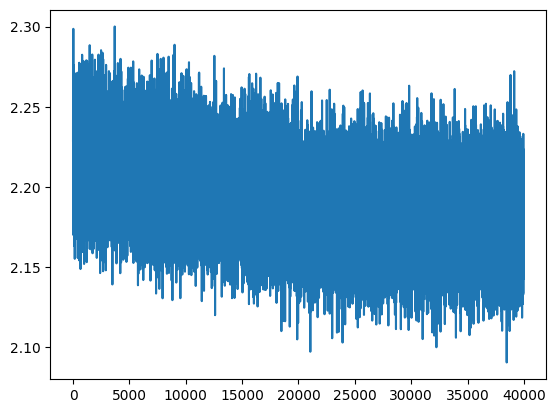

In [ ]:
# plot how the loss is being optimized at each step
plt.plot(stepi, lossi)

In [ ]:
# Evaluating the loss on the training dataset
emb = C[Xtr] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, C_featDim_size) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1803, grad_fn=<NllLossBackward0>)

In [ ]:
# Evaluating the loss on the dev dataset
emb = C[Xdev] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, C_featDim_size) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

# If the loss of the training dataset is ~ loss on the validation/dev dataset i.e. we are not overfitting else loss(training set) < loss(dev/validation data)
# then most likely the model is underfitting - i.e. the network is not powerful enough | its very tiny/small
# increase the side of the hidden layer neurons

tensor(2.2002, grad_fn=<NllLossBackward0>)

In [ ]:
# Evaluating the loss for the entire dataset
emb = C[X] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, C_featDim_size) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.1849, grad_fn=<NllLossBackward0>)

In [ ]:
print(lri)
print(lossi)

[]
[30.374000549316406, 21.192739486694336, 21.213510513305664, 20.61113739013672, 22.907567977905273, 20.34916114807129, 19.198476791381836, 19.726205825805664, 13.008708953857422, 16.537357330322266, 11.814537048339844, 11.888422012329102, 13.225090980529785, 18.110647201538086, 14.752625465393066, 10.174574851989746, 12.236241340637207, 10.33750057220459, 9.286839485168457, 13.202535629272461, 9.354783058166504, 9.646381378173828, 11.321537017822266, 9.794182777404785, 11.700278282165527, 10.09021282196045, 9.625262260437012, 7.751749515533447, 7.784210681915283, 8.739895820617676, 11.507575988769531, 7.815792083740234, 7.502581596374512, 9.257122039794922, 7.944190979003906, 9.282842636108398, 7.244825839996338, 9.909745216369629, 6.911200523376465, 7.569656848907471, 8.092569351196289, 4.190433502197266, 6.144077777862549, 6.368229389190674, 7.321793079376221, 7.3997802734375, 6.27793550491333, 7.100805759429932, 6.608521461486816, 5.748859882354736, 8.27238655090332, 4.7847905158

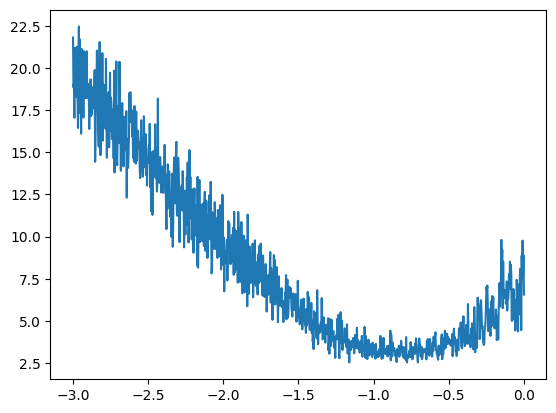

In [ ]:
# plot learning rate and corresponding loss
plt.plot(lri, lossi)
# in the beginning the learning rate is very small
# we have to find the good learning rate exponent

In [ ]:
# we see good learning rates are where the loss is the lowest
# from above plot its in the range of < -1.0
# this -1.0 is the valueo of the learning rate exponent lre
# i.e. a good learning rate is somehere around 10** -1.0 = 0.1
# so now we can go back and use that learning rate

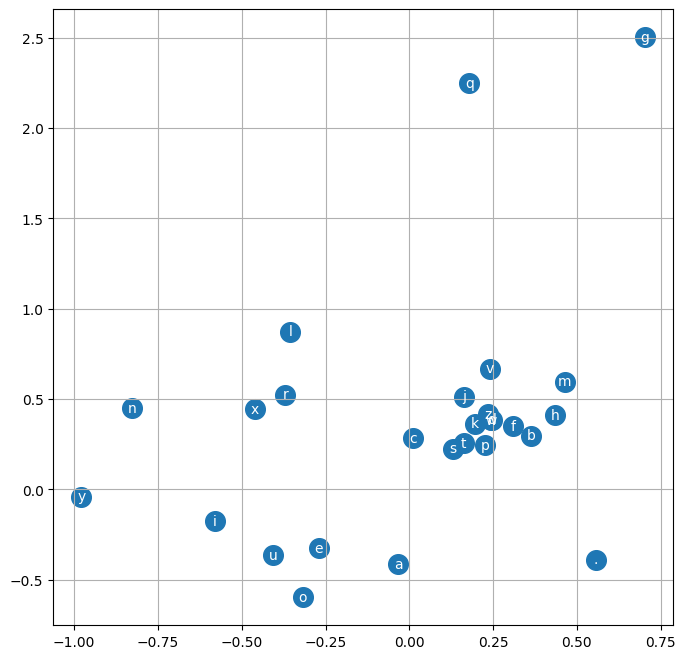

In [ ]:
# visualize word feature matrix (embeddings) that were trained by the neural net
# C -> |V| times m matrix
# where m=2 is the number of features in the matrix C
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 14)
block_size = 3 # context length
# sampling 20 names using the model
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ... | ie the starting point
  while True:
    emb = C[torch.tensor([context])] # (1, block_zise, m)
    #print(f'{torch.tensor([context]).shape=}')
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2 # similar to cross_entropy be careful that there are no overflows
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

cland.
johanceriel.
lan.
ramarostoev.
auona.
zadvie.
dohaikilanee.
ayla.
johabeica.
iniah.
galee.
jeelei.
ronik.
horrynn.
aymarro.
jeor.
amaris.
koon.
leab.
sia.
